# Data Science: AQI and Asthma Correlation

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/merged_data_LSTM.csv")

# Part 2.1 (2A)

# Part 2.2(2B)

## Dan's Model
Model 1 LSTM Forest for AQI threhold predictions and countie locations that are forecasted to have the most hospitilizations.

Epoch 1/250, Loss: 1.4618
Epoch 2/250, Loss: 1.2800
Epoch 3/250, Loss: 1.2532
Epoch 4/250, Loss: 1.2224
Epoch 5/250, Loss: 1.2177
Epoch 6/250, Loss: 1.2188
Epoch 7/250, Loss: 1.2884
Epoch 8/250, Loss: 1.2105
Epoch 9/250, Loss: 1.2104
Epoch 10/250, Loss: 1.1913
Epoch 11/250, Loss: 1.1957
Epoch 12/250, Loss: 1.1709
Epoch 13/250, Loss: 1.1973
Epoch 14/250, Loss: 1.1565
Epoch 15/250, Loss: 1.1604
Epoch 16/250, Loss: 1.1473
Epoch 17/250, Loss: 1.1510
Epoch 18/250, Loss: 1.1527
Epoch 19/250, Loss: 1.1589
Epoch 20/250, Loss: 1.1767
Epoch 21/250, Loss: 1.1615
Epoch 22/250, Loss: 1.1461
Epoch 23/250, Loss: 1.1607
Epoch 24/250, Loss: 1.1805
Epoch 25/250, Loss: 1.1904
Epoch 26/250, Loss: 1.1289
Epoch 27/250, Loss: 1.1229
Epoch 28/250, Loss: 1.1201
Epoch 29/250, Loss: 1.1126
Epoch 30/250, Loss: 1.1112
Epoch 31/250, Loss: 1.1136
Epoch 32/250, Loss: 1.1018
Epoch 33/250, Loss: 1.1316
Epoch 34/250, Loss: 1.1143
Epoch 35/250, Loss: 1.1170
Epoch 36/250, Loss: 1.1337
Epoch 37/250, Loss: 1.0917
Epoch 38/2

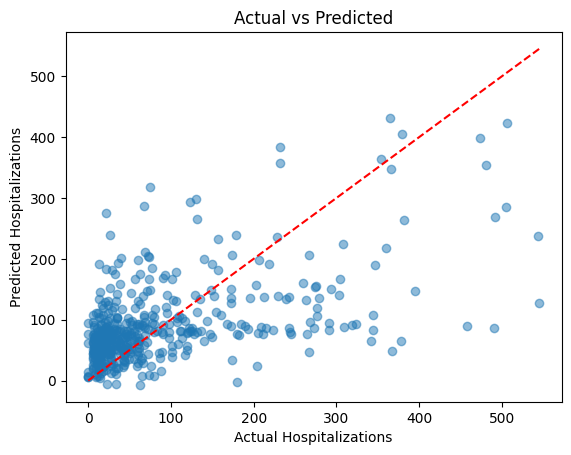

In [ ]:
'''
- Uses `torch.nn.LSTM` for sequence modeling
- Includes `train/test` split and loss evaluation
- Scales the data using `MinMaxScaler`
- Uses `MSELoss` for regression (hospitalizations)
'''


### PyTorch LSTM Model


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load your dataset (replace with your own path if running locally)
df = pd.read_csv('/content/merged_data_LSTM.csv')

# Clean and prepare
df_clean = df.drop(columns=['Data Comment', 'Unnamed: 7'])
df_clean = df_clean.dropna(subset=['Value'])
df_clean['Value'] = pd.to_numeric(df_clean['Value'], errors='coerce')
df_clean = df_clean.dropna(subset=['Value'])

# Feature columns
aqi_features = [
    'Days with AQI', 'Good Days', 'Moderate Days',
    'Unhealthy for Sensitive Groups Days', 'Unhealthy Days',
    'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
    '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
    'Days Ozone', 'Days PM2.5', 'Days PM10'
]

sequence_length = 5 # Number of years as a 5 chunked snapshot
X, y = [], []

for _, group in df_clean.groupby('CountyFIPS'):
    group_sorted = group.sort_values('Year')
    if len(group_sorted) < sequence_length + 1:
        continue
    features = group_sorted[aqi_features].values
    target = group_sorted['Value'].values
    for i in range(len(group_sorted) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Scale x features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)

# Scale y
y = y.reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y).flatten()


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y_scaled,
                                                    test_size=0.2,
                                                    random_state=42)

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out)

# Model, loss, optimizer
model = LSTMModel(input_dim=15, hidden_dim=64, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


# Training loop
epochs = 250
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    preds = model(X_test_torch)
    test_loss = criterion(preds, y_test_torch)
    print(f"\nTest Loss (MSE): {test_loss.item():.4f}")

# RMSE original Units (how many people is the model off by?)
preds = model(X_test_torch).detach().numpy()
rmse = np.sqrt(criterion(torch.tensor(preds), y_test_torch).item())
rmse_original = y_scaler.inverse_transform([[rmse]])[0][0]
print(f"RMSE (original units): {rmse_original:.2f}")


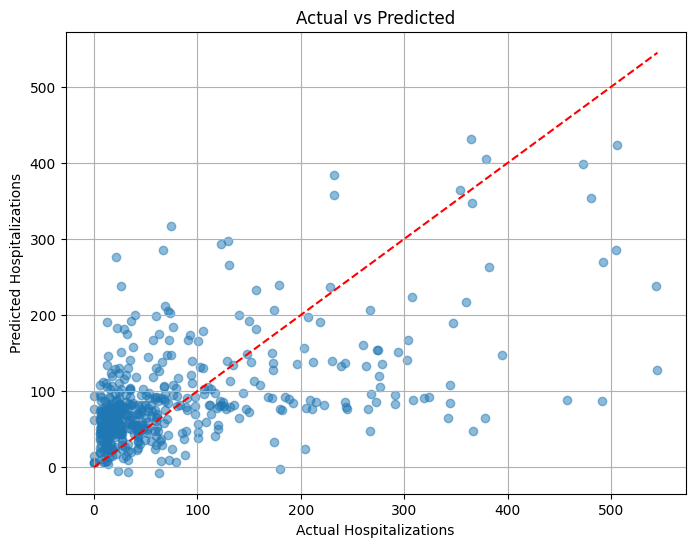

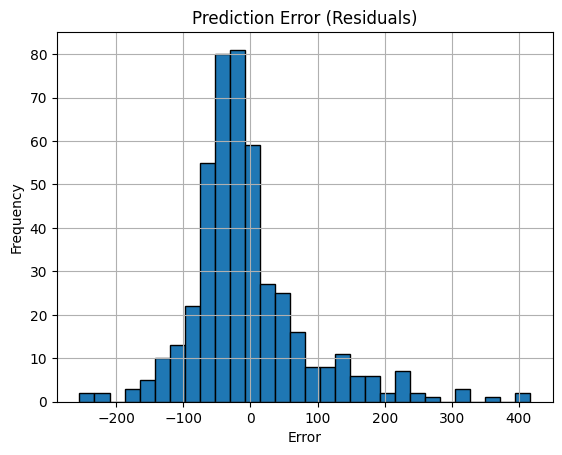

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.5)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
plt.xlabel("Actual Hospitalizations")
plt.ylabel("Predicted Hospitalizations")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

# Residuals
residuals = actual.flatten() - predicted.flatten()
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Prediction Error (Residuals)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [ ]:
# Save the Model
torch.save(model.state_dict(), "hospitalization_lstm_model.pth")


# Save scalers
import joblib

# Save the feature scaler
joblib.dump(scaler, "feature_scaler.pkl")

# Save the target scaler (for y)
joblib.dump(y_scaler, "target_scaler.pkl")


['target_scaler.pkl']

In [ ]:
# Load the saved model
import torch
import joblib
import numpy as np

# Redefine your model class (must match the one used in training)
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out)

# Load model weights and scalers
model = LSTMModel(input_dim=15, hidden_dim=64, output_dim=1)
model.load_state_dict(torch.load("/content/hospitalization_lstm_model.pth"))
print(model.eval())

scaler = joblib.load("/content/feature_scaler.pkl")
y_scaler = joblib.load("/content/feature_scaler.pkl")

LSTMModel(
  (lstm): LSTM(15, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:

# 🧱 Split dataset by year
train_df = df_clean[df_clean["Year"] <= 2017]
test_df = df_clean[df_clean["Year"] > 2017]


In [ ]:

# ⚙️ Function to create time sequences for LSTM
def create_sequences(df, sequence_length, aqi_features):
    X, y = [], []
    for _, group in df.groupby('CountyFIPS'):
        group_sorted = group.sort_values('Year')
        if len(group_sorted) < sequence_length + 1:
            continue
        features = group_sorted[aqi_features].values
        target = group_sorted['Value'].values
        for i in range(len(group_sorted) - sequence_length):
            X.append(features[i:i+sequence_length])
            y.append(target[i + sequence_length])
    return np.array(X), np.array(y)


In [ ]:

# 📚 Generate sequences for training and testing
sequence_length = 3  # You can adjust this to 5, etc.
X_train, y_train = create_sequences(train_df, sequence_length, aqi_features)
X_test, y_test = create_sequences(test_df, sequence_length, aqi_features)


In [ ]:

# 📏 Scale features using MinMaxScaler (fitted only on training data)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)


In [ ]:

# 🔄 Convert data to PyTorch tensors
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Part 2.2 (2B) Jordan's Model

# Part 2.3(2C) Model Output Analysis